## Explore GeoWiki processing code to exclude country 

### GeoWiki Processor

In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import sys
from collections import Counter
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import matplotlib.pyplot as plt

sys.path.append("..")

from src.processors import (
    GeoWikiProcessor,
    TogoProcessor,
)
from src.engineer import (
    GeoWikiEngineer,
    TogoEngineer,
    TogoEvaluationEngineer,
)
from src.models import STR2MODEL

In [2]:
processor = GeoWikiProcessor(Path('../data'))

In [3]:
location_data = processor.load_raw_data('all')

In [4]:
mean_per_location = (
            location_data[["location_id", "sumcrop", "loc_cent_X", "loc_cent_Y"]]
            .groupby("location_id")
            .mean()
        )

In [5]:
mean_per_location = mean_per_location.rename(
            {"loc_cent_X": "lon", "loc_cent_Y": "lat", "sumcrop": "mean_sumcrop"},
            axis="columns",
            errors="raise",
        )

In [6]:
output_xr = (
            mean_per_location.reset_index()
            .set_index(["lon", "lat"])["mean_sumcrop"]
            .to_xarray()
        )

### GeoWiki Engineer

In [7]:
xarr = xarray.open_dataset(processor.output_folder/'data.nc').to_dataframe().dropna().reset_index()

In [8]:
xarr['lon']

0       -68.75
1       -68.25
2       -68.75
3       -68.25
4       -69.75
         ...  
35861   -46.25
35862   -43.25
35863   -24.75
35864   -23.75
35865   -30.25
Name: lon, Length: 35866, dtype: float64

In [9]:
xarr

,lat,lon,mean_sumcrop
0,-54.547619,-68.75,0.0
1,-54.047619,-68.25,0.0
2,-53.547619,-68.75,0.0
3,-53.547619,-68.25,4.8
4,-53.047619,-69.75,0.0
...,...,...,...
35861,82.452381,-46.25,0.0
35862,82.452381,-43.25,0.0
35863,82.452381,-24.75,0.0
35864,82.452381,-23.75,0.0


In [10]:
engineer = GeoWikiEngineer(Path('../data'))

In [11]:
engineer.eval_only

False

In [12]:
engineer.labels # same as 'data.nc'

,lat,lon,mean_sumcrop
0,-54.547619,-68.75,0.0
1,-54.047619,-68.25,0.0
2,-53.547619,-68.75,0.0
3,-53.547619,-68.25,4.8
4,-53.047619,-69.75,0.0
...,...,...,...
35861,82.452381,-46.25,0.0
35862,82.452381,-43.25,0.0
35863,82.452381,-24.75,0.0
35864,82.452381,-23.75,0.0


#### Recreate process_single_file() function in engineer/geowiki.py

In [13]:
tif_example_path = engineer.geospatial_files[0]
tif_example_path

PosixPath('../data/raw/earth_engine_geowiki/1060_2017-03-28_2018-03-28.tif')

In [14]:
file_info = engineer.process_filename(tif_example_path.name, True)
file_info

('1060',
 datetime.datetime(2017, 3, 28, 0, 0),
 datetime.datetime(2018, 3, 28, 0, 0))

In [15]:
val_set_size = 0.2
test_set_size = 0.0
if engineer.eval_only:
    data_subset = "testing"
else:
    random_float = np.random.uniform()
    # we split into (val, test, train)
    if random_float <= (val_set_size + test_set_size):
        if random_float <= val_set_size:
            data_subset = "validation"
        else:
            data_subset = "testing"
    else:
        data_subset = "training"                

In [16]:
data_subset

'training'

In [17]:
da = engineer.load_tif(tif_example_path, days_per_timestep=30, start_date=file_info[1])
da

<xarray.DataArray 'FEATURES' (time: 12, band: 13, y: 17, x: 20)>
array([[[[0.5254, 0.5254, 0.5254, ..., 0.4357, 0.4357, 0.4357],
         [0.5254, 0.5254, 0.5254, ..., 0.4357, 0.4357, 0.4357],
         [0.5254, 0.5254, 0.5254, ..., 0.4357, 0.4357, 0.4357],
         ...,
         [0.5442, 0.5442, 0.5442, ..., 0.3065, 0.3065, 0.2662],
         [0.5442, 0.5442, 0.5442, ..., 0.3065, 0.3065, 0.2662],
         [0.5442, 0.5442, 0.5442, ..., 0.3065, 0.3065, 0.2662]],

        [[0.5138, 0.5151, 0.518 , ..., 0.448 , 0.4359, 0.4359],
         [0.5073, 0.509 , 0.5104, ..., 0.445 , 0.4339, 0.4339],
         [0.4946, 0.4966, 0.5023, ..., 0.434 , 0.4254, 0.4254],
         ...,
         [0.5551, 0.5375, 0.5375, ..., 0.2314, 0.2202, 0.2194],
         [0.5594, 0.5391, 0.5391, ..., 0.2145, 0.2083, 0.218 ],
         [0.5635, 0.5479, 0.5479, ..., 0.198 , 0.1953, 0.2066]],

        [[0.4815, 0.4843, 0.4872, ..., 0.4256, 0.413 , 0.413 ],
         [0.4698, 0.4726, 0.486 , ..., 0.4173, 0.402 , 0.402 ],
         [0.4644, 0.4579, 0.4666, ..., 0.3978, 0.3863, 0.3863],
         ...,
...
         ...,
         [0.0017, 0.0017, 0.0017, ..., 0.0016, 0.0016, 0.0019],
         [0.0017, 0.0017, 0.0017, ..., 0.0016, 0.0016, 0.0019],
         [0.0018, 0.0018, 0.0018, ..., 0.0018, 0.0018, 0.002 ]],

        [[0.4195, 0.4147, 0.4147, ..., 0.4353, 0.4353, 0.4533],
         [0.41  , 0.4014, 0.4014, ..., 0.4377, 0.4377, 0.4502],
         [0.41  , 0.4014, 0.4014, ..., 0.4377, 0.4377, 0.4502],
         ...,
         [0.4367, 0.4371, 0.4371, ..., 0.4249, 0.4249, 0.4472],
         [0.4365, 0.4368, 0.4368, ..., 0.43  , 0.43  , 0.4494],
         [0.4453, 0.4439, 0.4439, ..., 0.44  , 0.44  , 0.4573]],

        [[0.3457, 0.3384, 0.3384, ..., 0.3734, 0.3734, 0.3708],
         [0.3268, 0.3224, 0.3224, ..., 0.3761, 0.3761, 0.3724],
         [0.3268, 0.3224, 0.3224, ..., 0.3761, 0.3761, 0.3724],
         ...,
         [0.3721, 0.3723, 0.3723, ..., 0.354 , 0.354 , 0.3575],
         [0.377 , 0.377 , 0.377 , ..., 0.3622, 0.3622, 0.3619],
         [0.3762, 0.3762, 0.3762, ..., 0.3633, 0.3633, 0.3639]]]])
Coordinates:
  * band     (band) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * y        (y) float64 -32.75 -32.75 -32.75 -32.75 ... -32.75 -32.75 -32.75
  * x        (x) float64 138.7 138.7 138.7 138.7 ... 138.7 138.7 138.7 138.7
  * time     (time) datetime64[ns] 2017-03-28 2017-04-27 ... 2018-02-21
Attributes:
    band_descriptions:  ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A...

In [18]:
min_lon, min_lat = float(da.x.min()), float(da.y.min())
max_lon, max_lat = float(da.x.max()), float(da.y.max())
# Get the "labelled pixel" that this tif contains (kind of filtering engineer.lables by a bounding box given by tif bounds)
overlap = engineer.labels[
            (
                (engineer.labels.lon <= max_lon)
                & (engineer.labels.lon >= min_lon)
                & (engineer.labels.lat <= max_lat)
                & (engineer.labels.lat >= min_lat)
            )
        ]

In [19]:
overlap

,lat,lon,mean_sumcrop
1060,-32.75,138.651786,25.0


In [20]:
label_lat = overlap.iloc[0].lat
label_lon = overlap.iloc[0].lon

# we turn the percentage into a fraction
crop_probability = overlap.iloc[0].mean_sumcrop / 100

# find the x,y of the pixel that matches the label better
closest_lon = engineer.find_nearest(da.x, label_lon)
closest_lat = engineer.find_nearest(da.y, label_lat)

In [21]:
label_lat, closest_lat

(-32.75, -32.75001506043801)

In [22]:
label_lon, closest_lon

(138.65178569999998, 138.6517750845895)

In [23]:
crop_probability

0.25

In [24]:
labelled_np = da.sel(x=closest_lon).sel(y=closest_lat).values

In [25]:
da.sel(x=closest_lon).sel(y=closest_lat).values.shape

(12, 13)

In [26]:
instance = engineer.process_single_file(
                path_to_file=tif_example_path,
                nan_fill=0.0,
                max_nan_ratio=0.3,
                add_ndvi=True,
                calculate_normalizing_dict=False,
                start_date=file_info[1],
                days_per_timestep=30,
                is_test=True if data_subset == "testing" else False,
)

In [27]:
instance

GeoWikiDataInstance(label_lat=-32.75, label_lon=138.65178569999998, instance_lat=-32.75001506043801, instance_lon=138.6517750845895, labelled_array=array([[0.4853    , 0.5092    , 0.475     , 0.5008    , 0.5131    ,
        0.5211    , 0.54      , 0.5623    , 0.5529    , 0.3012    ,
        0.0069    , 0.486     , 0.3653    , 0.05784968],
       [0.182     , 0.1192    , 0.1168    , 0.1163    , 0.1481    ,
        0.2243    , 0.2554    , 0.2126    , 0.2834    , 0.1071    ,
        0.003     , 0.2346    , 0.1951    , 0.29279416],
       [0.1376    , 0.109     , 0.1053    , 0.1141    , 0.1593    ,
        0.2346    , 0.2739    , 0.2571    , 0.2987    , 0.115     ,
        0.0016    , 0.3003    , 0.2016    , 0.38523707],
       [0.2232    , 0.2412    , 0.2081    , 0.2176    , 0.2376    ,
        0.2899    , 0.316     , 0.3421    , 0.343     , 0.1162    ,
        0.0017    , 0.3061    , 0.2109    , 0.22244059],
       [0.128     , 0.1106    , 0.1091    , 0.1338    , 0.1646    ,
        0.22

In [28]:
togoeval_engineer = TogoEvaluationEngineer(Path('../data'))

In [29]:
togoeval_engineer.eval_only

True

## Filter engineer.labels by Nigeria and create splits

Probably can't trust the identifier of the tif files to be the same as the index in the data.nc file, so will need to load all tifs of geowiki in order to get the lat/lon and get the subset inside a country and leave them out the training set. Make a function modifying base.py --> engineer() to get the lat/lon of each instance (output of process_single_file fuction) together with the identifier. Then transfrom this into a geodataframe to make a column of which country the fall on, which I can then use to create my custom train/val/test splits out of geowiki.
<br/>
<br/>
**Steps**:
1. Loop over the geospatial files and append the lat/lon of each instance as well as the identifier to a tuple.
2. Convert into geospatial dataframe
3. Get shapefile of India and Nigeria (perhaps from CropHarvest) to see which labels (identifiers) fall there (or merge with shp of a country to add a column for each country of labels)
4. Separate .pkl files of the country of interest
5. Assing .pkl files of country of interest to val/test splits
6. Assign remaiding geowiki points to train/val split
7. Create normalization dictionary from train and val sets

**1. Match identifier with lat/lon of label**

The following block originally is meant to go inside the for loop processing each file. I just copied it here to have the data_subset variable define so it doesn't complain leater.

In [30]:
val_set_size = 0.2
test_set_size = 0.0
if engineer.eval_only:
    data_subset = "testing"
else:
    random_float = np.random.uniform()
    # we split into (val, test, train)
    if random_float <= (val_set_size + test_set_size):
        if random_float <= val_set_size:
            data_subset = "validation"
        else:
            data_subset = "testing"
    else:
        data_subset = "training"                

In [31]:
random_float

0.3745401188473625

In [32]:
target_file = 'identifiers_plus_cropland_prob.csv'
path = engineer.savedir / target_file
if path.exists():
    df = pd.read_csv(engineer.savedir / target_file)
    print(f'File {target_file} loaded!')
else:
    tuples = []
    for file_path in engineer.geospatial_files:
        file_info = engineer.process_filename(file_path.name, True)
        if file_info is None:
            continue
        identifier, start_date, end_date = file_info
        file_name = f"{identifier}_{str(start_date.date())}_{str(end_date.date())}"

        instance = engineer.process_single_file(
                    file_path,
                    nan_fill=0.0,
                    max_nan_ratio=0.3,
                    add_ndvi=True,
                    calculate_normalizing_dict=False,
                    start_date=start_date,
                    days_per_timestep=30,
                    is_test=True if data_subset == "testing" else False,
                )
        tuples.append((identifier, instance.instance_lat, instance.instance_lon, instance.crop_probability))
        
    df = pd.DataFrame(tuples, columns=['identifier', 'lat', 'lon', 'crop_probability'])
    df.to_csv(engineer.savedir / target_file, index=False)
    print(f'File {target_file} written to disk!')

File identifiers_plus_cropland_prob.csv loaded!


In [33]:
df = df.sort_values(by=['identifier']).reset_index(drop=True)

In [34]:
df

,identifier,lat,lon,crop_probability
0,0,-54.547635,-68.750000,0.000
1,1,-54.047633,-68.249998,0.000
2,2,-53.547631,-68.750000,0.000
3,3,-53.547631,-68.249998,0.048
4,4,-53.047629,-69.750005,0.000
...,...,...,...,...
35594,35610,60.952354,73.750023,0.140
35595,35611,60.952354,163.749985,0.000
35596,35612,60.952354,50.250005,0.600
35597,35614,61.249966,22.952360,0.130


**2. Convert into geospatial dataframe**

In [35]:
geowiki_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [36]:
geowiki_points

,identifier,lat,lon,crop_probability,geometry
0,0,-54.547635,-68.750000,0.000,POINT (-68.75000 -54.54764)
1,1,-54.047633,-68.249998,0.000,POINT (-68.25000 -54.04763)
2,2,-53.547631,-68.750000,0.000,POINT (-68.75000 -53.54763)
3,3,-53.547631,-68.249998,0.048,POINT (-68.25000 -53.54763)
4,4,-53.047629,-69.750005,0.000,POINT (-69.75000 -53.04763)
...,...,...,...,...,...
35594,35610,60.952354,73.750023,0.140,POINT (73.75002 60.95235)
35595,35611,60.952354,163.749985,0.000,POINT (163.74999 60.95235)
35596,35612,60.952354,50.250005,0.600,POINT (50.25001 60.95235)
35597,35614,61.249966,22.952360,0.130,POINT (22.95236 61.24997)


<AxesSubplot:>

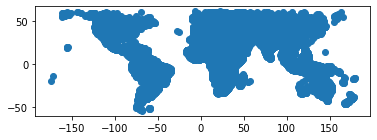

In [37]:
geowiki_points.plot()

**3. Get shape file of India and Nigeria and get identifiers of geowiki that fall there**

In [38]:
#world_map = gpd.read_file('/home/gajo/miniconda3/envs/mlcropland-himachal/lib/python3.9/site-packages/cropharvest/country_shapefile/ne_50m_admin_0_countries.shp')
world_map = gpd.read_file('../assets/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')

<AxesSubplot:>

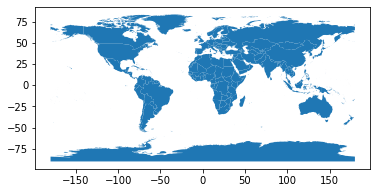

In [39]:
world_map.plot()

<AxesSubplot:>

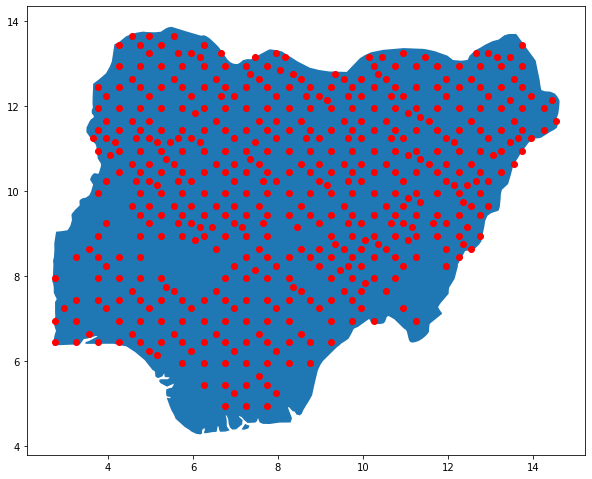

In [40]:
country = 'Nigeria' # 'India'
country_shp = world_map[world_map['SOVEREIGNT'] == country].reset_index(drop=True)

country_points_mask = geowiki_points.within(country_shp.loc[0, 'geometry'])
country_points = geowiki_points.loc[country_points_mask]

#Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
country_shp.plot(ax=ax)
country_points.plot(ax=ax,color='red')

In [41]:
ids = country_points['identifier'].values.tolist()
len(ids)

490

In [42]:
print(country_points.crs)

None


In [43]:
country_points
country_points = country_points.set_crs('epsg:4326')

In [44]:
country_points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [45]:
country_points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
out_path = Path(f'/mnt/N/dataorg-datasets/MLsatellite/cropland-GEE-data/Global/Geowiki/country_points/{country}_points.shp')
if not path.exists():
    country_points.to_file(out_path)
    print(f'File {out_path} written to disk!')

**4. Separate .pkl files from country of interest into validation set**

Easiest is to just use the processed .pkl files and move them around for train/val/test. I have already created a folder and copied all the processed geowiki files with bash commands

In [67]:
subfolder = 'fully_exclude_nigeria'
pkl_files = list((engineer.savedir / subfolder / 'all').glob('*.pkl'))

In [68]:
len(pkl_files)

35599

The previously defined ids variable contains the geowiki files identifiers belonging to the target country. We can use it to filter the pickle files.

In [69]:
files = []
for file_path in pkl_files:
    file_info = engineer.process_filename(file_path.name, True)
    identifier, start_date, end_date = file_info
    if int(identifier) in ids:
        files.append(file_path)

In [70]:
len(files), files[0]

(490,
 PosixPath('../data/features/geowiki_landcover_2017/fully_exclude_nigeria/all/11281_2017-03-28_2018-03-28.pkl'))

Create validation folder and move all Nigeria files there

In [71]:
data_subset = 'validation'
target_folder = engineer.savedir / subfolder / data_subset
target_folder.mkdir(exist_ok=True)

In [72]:
for file in files:
    file.rename(target_folder / file.name)

**5. Assign .pkl files of country of interest to val/test splits**

In [74]:
files = list((engineer.savedir / subfolder / 'validation').glob('*.pkl'))

In [75]:
len(files)

490

**IMPORTANT: note that this is only random splitting without considering spatial correlation**

In [76]:
np.random.seed(0)
test_set_size = 0.7  #given that for validation we still have geowiki data

for file in files:
    random_float = np.random.uniform()
    # Move to testing folder only if 
    if random_float <= test_set_size:
        data_subset = "testing"
        target_folder = engineer.savedir / subfolder / data_subset
        target_folder.mkdir(exist_ok=True)
        file.rename(target_folder / file.name)

**6. Assign remaining geowiki points to train/val split**

In [77]:
pkl_files_rest = list((engineer.savedir / subfolder / 'all').glob('*.pkl'))

In [78]:
len(pkl_files_rest)

35109

In [79]:
data_subset = 'training'
target_folder = engineer.savedir / subfolder / data_subset
target_folder.mkdir(exist_ok=True)

In [80]:
for file in pkl_files_rest:
    file.rename(target_folder / file.name)

Split geowiki between training and validation

In [81]:
pkl_files_rest = list((engineer.savedir / subfolder / 'training').glob('*.pkl'))

In [82]:
len(pkl_files_rest)

35109

In [83]:
np.random.seed(0)
val_set_size = 0.2
test_set_size = 0.0

for file in pkl_files_rest:
    # Determine where to move file 
    if engineer.eval_only:
        data_subset = "testing"
    else:
        random_float = np.random.uniform()
        # we split into (val, test, train)
        if random_float <= (val_set_size + test_set_size):
            if random_float <= val_set_size:
                data_subset = "validation"
            else:
                data_subset = "testing"
        else:
            data_subset = "training"
    # Move file
    target_path = engineer.savedir / subfolder / data_subset / file.name   
    file.rename(target_path)

In [84]:
(engineer.savedir / subfolder / 'all').rmdir()

Final split results in approx. 78.5%/20.5%/1%: ((27957+7301+351)/35599)

**7. Create normalizing dictionaries from training and validation set**

Normally the normalizing dict is created when using the engineer, but since we create this folder in another way, we need to create it manually.

We initialize a model so to be able to access the train, val data loaders to create the normalizing dictionary 

In [15]:
#Get model default args
parser = ArgumentParser()
model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[]) 
model_args_dict = vars(model_args)

# Change default hyperparameters
model_args_dict['add_togo'] = False
model_args_dict['multi_headed'] = False
model_args_dict['num_classification_layers'] = 1
model_args_dict['remove_b1_b10'] = False

# Initialize model
model_args = Namespace(**model_args_dict)
model = STR2MODEL["land_cover"](model_args)
model.hparams

Number of geowiki instances in training set: 27947


Namespace(add_geowiki=True, add_togo=False, alpha=10, batch_size=64, data_folder='/home/gajo/code/togo-crop-mask/notebooks/../data', hidden_vector_size=64, learning_rate=0.001, rnn_dropout=0.2, model_base='lstm', multi_headed=False, num_classification_layers=1, num_rnn_layers=1, probability_threshold=0.5, remove_b1_b10=False)

In [16]:
# Calculate normalizing dict of folder with custom split
if not model.normalizing_dict:
    engineer = GeoWikiEngineer(Path('../data'))
    
    # Use both train and val data loaders
    for batch in model.train_dataloader(): # This won't create the normalizing dict so val values will be the raw ones
        batch_x, batch_y, batch_weight = batch
        for x in batch_x:
            engineer.update_normalizing_values(x.numpy())

    for batch in model.val_dataloader():
        batch_x, batch_y, batch_weight = batch
        for x in batch_x:
            engineer.update_normalizing_values(x.numpy())

    normalizing_dict = engineer.calculate_normalizing_dict()
    model.normalizing_dict = normalizing_dict

    savedir = model.data_folder / "features" / engineer.dataset / 'fully_exclude_nigeria'
    if normalizing_dict is not None:
        save_path = savedir / "normalizing_dict.pkl"
        with save_path.open("wb") as f:
            pickle.dump(normalizing_dict, f)
    else:
        print("No normalizing dict calculated!")
else:
    print('Normalizing dict already exists and can be access through model.normalizing_dict.')

Normalizing dict already exists and can be access through model.normalizing_dict.
